# Librerías

In [38]:
import pandas as pd
from summarytools import dfSummary

import matplotlib.pyplot as plt
import seaborn as sns

# 1. A partir del dataset ruidoso.txt realice los siguientes análisis:

## a. Cargue y explore el dataset explicando en qué consiste y las características que posee el mismo.

In [13]:
ruidoso = pd.read_csv("data/ruidoso.txt")

Se usa la función **read_csv** de pandas para leer la información contenida en el archivo ruidoso.txt, y se guarda esta en un objeto llamado **ruidoso**.

In [27]:
dfSummary(ruidoso, is_collapsible=False)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Road_55dB[int64],Mean (sd) : 159228.8 (484751.3)min < med < max:7600.0 < 37550.0 < 3108200.0IQR (CV) : 59950.0 (0.3),61 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB40lEQVR4nO3XsU7CUBSH8XNEsUTpDUUZeQBMfAB2HX1YV3dWBl+CpZFWY4kNuW4uJmIvGvzH7zf33HuTfm1TjzEa8NcdHfoAwHcc77rA3Qdm1k9c/y3G2CTOAh++DNXdB+Px+C7P81HK4nVdP7n7PbFiX7veqP08z0fz+bwJIWy6LFxVVbZYLEZlWfbNjFCxl52ffjOzEMJmMpm8Jqw/SJgBPuFnChIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRIIFRKOD32Ar7j7wMz6ieNvMcbmJ8+Dw/nVULfb7YmZ5e6eMp4VRXEbQjhLGa7r+snd7/9brId8uH9z72+FWlVV1nXX1Wo1bNv2ejqd9nq93qbrfNu2mZldzWazx+Fw+Nxltmma0+VyeVmW5YW71133FpYVRXETQjhPGV6v1y/u/mBmne/XvnvverG8A+3sY8cpONmSAAAAAElFTkSuQmCC"">",0(0.0%)
2,Road_60dB[int64],Mean (sd) : 78587.9 (251409.0)min < med < max:4000.0 < 17400.0 < 1469100.0IQR (CV) : 24425.0 (0.3),63 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB80lEQVR4nO3XQW7aQBiG4f8vqYNVmJFxw5IDUIkDcIAuc9gcgi0SvQSbUWRXqmlc5O66aQXxpGn6Se+z5huP5FcgfBgGA/537976AsBz3Fz7gLuXZlZknv80DEOXuQV+uRiqu5d1Xd+HEKqcw9u2fXT3B2LFS137Ri1CCNV2u+1ijKcxBzdNM93tdlVKqTAzQsWLXP3pNzOLMZ6Wy+W3jPPLjA3wG/5MQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQsLNW1/gEncvzazInD8Nw9D9zfvgstd8X68a6vl8fm9mwd1z5tPFYvE5xvghZ9y27aO7PxDrv+HuZV3X9yGEKmd/7X09K9SmaaZjH3w8Hud9329Wq9VkMpmcxu77vp+a2af1ev1lPp9/HbPtuu52v9/fpZQ+uns79tnIEmaz2d1ms/lRluX3McOu624Ph0OVUirM7I+h/gS4/GS7jFUA0wAAAABJRU5ErkJggg=="">",0(0.0%)
3,Railways_65dB[int64],Mean (sd) : 1139.4 (4778.8)min < med < max:0.0 < 100.0 < 29700.0IQR (CV) : 400.0 (0.2),18 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABpUlEQVR4nO3XQWrbUBSG0feMa2wwErbBG+guPM+0i80ivIsuwQQJXIcEVZ11ElLHMjT54ZypdK/e4ENCdRzHAl/d7LMPAB8xv3ZDrXVVSllM3P8yjuNl4iz89c9Qa62r3W73o2mazZTlfd8/1Vofxcq9rr1RF03TbA6Hw6Vt2+dbFnddtzwej5vT6bQopQiVu1z99JdSStu2z/v9/teE/asJM/CGnykiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUIQiWCUIkgVCIIlQhCJYJQiSBUIgiVCEIlglCJIFQiCJUI888+AF9HrXVVSlncsWJWSvk9cfZlHMfLexc/FGrXdctbn9p13XIYhnkppam13jrO/7fcbrcPbduupwwPw/DtfD5/X6/XP2ez2eut833fP9VaH9+L9Q//c0Aw9BjlPwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Industry_65dB[float64],1. 0.02. 100.03. 300.04. 200.05. 400.06. 1300.07. 900.08. 800.09. 600.010. 4000.011. other,41 (62.1%)8 (12.1%)5 (7.6%)3 (4.5%)3 (4.5%)1 (1.5%)1 (1.5%)1 (1.5%)1 (1.5%)1 (1.5%)1 (1.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8qNh9FAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8UlEQVR4nO3dQW7bVgBF0S/BSOuJBMOAl+EFeBFdbBehBXgfhmEOqjQTddCi6MQJqNCXhXnOCj6CGwok/kt2l8tlQGG/9gHYDrGRERsZsZERGxmxkREbGbGRERuZ3RjjdozxZe2DbNi3y+VyXvsQhZv7+/vfDofD3doH2appml53u93vWwju5nA43D09PZ2Px+PXtQ+zNW9vb7+eTqe7l5eXL2OMzx/bGGMcj8evDw8Pf6x9mI26XfsAFS8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5maMv+9VrX2QLdran/vNNE2vp9PpbmzoXtX/yTRNr2OMb2ufo2CDsL7NbBB2/sksKks/2Tbzt5T5Fl1XbWkpxHyLrau2thRivqXXVd5oeZePumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQWG7xsbbzBfIsOXrY03mA+18LJGLyQuebJ5unFVWYPXoxauNaswYtRCz/jmsG

A continuación se crea una función de usuario para verificar si una lista de valores son todos consecutivos y distintos entre sí.

In [15]:
def son_diferentes_consecutivos(lista):
    for i in range(len(lista) - 1):
        if lista[i] == lista[i + 1]:
            return False
        if lista[i] + 1 != lista[i + 1]:
            return False
    return True

# Verificar si los valores son diferentes y consecutivos
variable = "Unnamed: 0"
if son_diferentes_consecutivos(ruidoso[variable]):
    print(f"Los valores de la variable {variable} son diferentes y consecutivos.")
else:
    print(f"Los valores de la variable {variable} no son diferentes y consecutivos.")

Los valores de la variable Unnamed: 0 son diferentes y consecutivos.


Las variables en este archivo parecen representar diferentes tipos de ruido (presumiblemente en diferentes áreas o ubicaciones), y los valores numéricos parecen ser mediciones de niveles de ruido en decibelios (dB) en diferentes condiciones ambientales.

Una descripción tentativa de las variables podría ser:

- Road_55dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 55 decibelios (dB).

- Road_60dB: Esta variable parece representar mediciones de ruido provenientes de carreteras con un nivel de 60 decibelios (dB).

- Railways_65dB: Esta variable parece representar mediciones de ruido provenientes de ferrocarriles con un nivel de 65 decibelios (dB).

- Industry_65dB: Esta variable parece representar mediciones de ruido provenientes de industrias con un nivel de 65 decibelios (dB).

Con la ayuda de la función **dfSummary**, se obtiene un resumen del dataframe **ruidoso**. se puede observar que este dataframe tiene una dimensión de 66 filas y 5 columnas, no tiene duplicados y las 5 variables son numéricas, sin embargo, la primera variable **Unnamed: 0** contiene 66 valores distintos que va desde 1 hasta 66 (verificado con la función de usuario), por lo que en realidad esta variable es un índice del dataframe y no una variable como tal. Por último, se puede observar que la variable **Industry_65dB** tiene un valor faltante, y dicho valor faltante está afectando la salida de los estadísticos de resumen tales como la media y la mediana de esta variable, por lo tanto, se usará otra función para conocer los estadísticos de resumen de esta.

In [16]:
ruidoso.set_index('Unnamed: 0', drop=True, inplace=True)
ruidoso.index.name = None 
ruidoso

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
1,166400,79200,1100,0.0
2,20000,11000,0,0.0
3,37800,18000,0,0.0
4,24500,16700,0,100.0
5,103100,33500,1900,200.0
...,...,...,...,...
62,20700,16200,0,0.0
63,15100,9900,0,0.0
64,24500,12400,300,300.0
65,12800,8500,0,0.0


Del anterior código, la variable **Unnamed: 0** se transformó en índece.

In [33]:
ruidoso.describe()

,Road_55dB,Road_60dB,Railways_65dB,Industry_65dB
count,6.600000e+01,6.600000e+01,66.000000,65.000000
mean,1.592288e+05,7.858788e+04,1139.393939,180.000000
std,4.847513e+05,2.514090e+05,4778.827625,537.993959
min,7.600000e+03,4.000000e+03,0.000000,0.000000
25%,1.895000e+04,1.007500e+04,0.000000,0.000000
50%,3.755000e+04,1.740000e+04,100.000000,0.000000
75%,7.890000e+04,3.450000e+04,400.000000,100.000000
max,3.108200e+06,1.469100e+06,29700.000000,4000.000000


Usando la función **describe** se obtiene los estadísticos de resumen para la variable **Industry_65dB** que no se pudo obtener usando la función **dfSummary** debido el valor faltante. De esta forma, se puede observar que la media de estas 4 variables numéricas es mayor a la mediana, por lo que se espera que la distribución de cada una de estas variables sea sesgada hacia la derecha como visto en los histogramas de la función **dfSummary**. También, se puede observar que la variabilidad presente en cada una de estas variables es relativamente alta. Por lo último, también se tiene el mínimo, los percentiles, y el máximo de cada una de las variables.

## b. Realice un breve análisis exploratorio para identificar la distribución de las variables usadas en la base de datos ¿será que existe relación entre las variables?

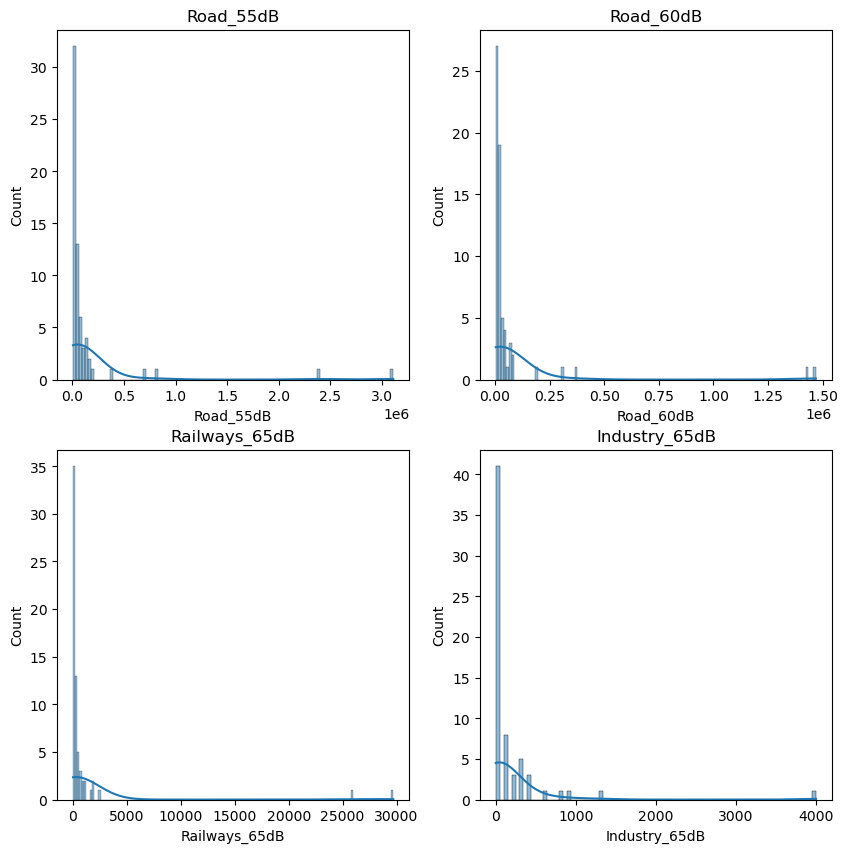

In [44]:
# Crear una figura y ejes utilizando subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Crear gráficos de distribución para cada variable en la cuadrícula de ejes
sns.histplot(ruidoso['Road_55dB'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Road_55dB')

sns.histplot(ruidoso['Road_60dB'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Road_60dB')

sns.histplot(ruidoso['Railways_65dB'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Railways_65dB')

sns.histplot(ruidoso['Industry_65dB'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Industry_65dB')

plt.show()

De las anteriores gráficas, se puede observar que la distribución de cada una de las variables tienen formas muy parecidas, especialmente entre las variables **Road_55dB** y **Road_60dB**. Por lo tanto, se puede creer que estas variables tengan algún tipo de relación, para esto, se usará gráficas y medidas de correlación.

## c. Verifique si existen problemas de datos atípicos en cada una de las variables usando las metodologías de detección a nivel univariado.

## d. ¿Se detectan valores atípicos a nivel multivariado?

## e. Para el caso univariado, escoja una variable y realice un análisis sobre las implicaciones que tiene realizar diferentes tratamientos a los datos atípicos en la distribución de la respectiva variable.